# Demonstration of Cython

## Examples

* [cd_fast.pyx in scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/linear_model/cd_fast.pyx)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%load_ext Cython
%autoreload 1

## Classical Fibonacci Function

* [Basic Tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)

In [2]:
def fib(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b
    return a

In [3]:
%timeit fib(1000)

1.31 µs ± 7.64 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [4]:
%%cython -a

def c_fib(n):
    a, b = 0, 1
    while b < n:
        a, b = b, a + b
    return a

In [5]:
%timeit c_fib(1000)

642 ns ± 6.06 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [6]:
%%cython -a

cpdef int c_fib_typed(int n) except *:
    cdef int a = 0
    cdef int b = 1
    while b < n:
        a, b = b, a + b
    return a

In [7]:
%timeit c_fib_typed(1000)

94.6 ns ± 0.879 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [8]:
%%cython -a
cimport cython as c
def c_fib_annot(n: c.int) -> c.int:
    a:c.int = 0
    b:c.int = 1
    while b < n:
        a, b = b, a + b
    return a

In [9]:
%timeit c_fib_annot(1000)

95 ns ± 0.52 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


## Primes

In [10]:
def primes(nb_primes):
    p = []
    n = 2
    while len(p) < nb_primes:
        for i in p:
            if n % i == 0:
                break
        else:
            p.append(n)
        n += 1
    return p

In [11]:
%timeit primes(1000)

38.6 ms ± 929 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%cython -a

def c_primes(nb_primes):
    p = []
    n = 2
    while len(p) < nb_primes:
        for i in p:
            if n % i == 0:
                break
        else:
            p.append(n)
        n += 1
    return p

In [13]:
%timeit c_primes(1000)

18.3 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%cython -a
cimport cython as c

@c.cdivision(True)
def c_primes_typed(int nb_primes):
    cdef int n, i, len_p
    cdef int p[1000]
    if nb_primes > 1000:
        nb_primes = 1000

    len_p = 0  # The current number of elements in p.
    n = 2
    while len_p < nb_primes:
        for i in p[:len_p]:
            if n % i == 0:
                break
        else:
            p[len_p] = n
            len_p += 1
        n += 1

    result_as_list  = [prime for prime in p[:len_p]]
    return result_as_list

In [15]:
%timeit c_primes_typed(1000)

2.08 ms ± 37.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Numpy

* [Cython for NumPy Users](http://docs.cython.org/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial)
* [Typed Memoryviews](https://cython.readthedocs.io/en/latest/src/userguide/memoryviews.html)

In [16]:
import numpy as np
X = np.array([[1,2,3], [4,5,6], [7,8,9]]).astype(np.int)

### Soft Thresholding Function

In [17]:
def soft_threshold(X: np.ndarray, thresh: float) -> np.ndarray:
    return np.where(np.abs(X) <= thresh, 0, X - thresh * np.sign(X))

In [18]:
%timeit soft_threshold(X, 3)

6.74 µs ± 976 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [19]:
%%cython -a
import numpy as np

def c_soft_threshold(X, thresh):
    return np.where(np.abs(X) <= thresh, 0, X - thresh * np.sign(X))

In [20]:
%timeit c_soft_threshold(X, 3)

8.27 µs ± 298 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
%%cython -a
import numpy as np
cimport numpy as np

cimport cython

ctypedef fused numeric:
    np.int32_t
    np.int64_t    
    np.float32_t
    np.float64_t

    
cdef int sign(numeric X):
    return (X > 0) - (0 > X)
    
    
@cython.boundscheck(False)
@cython.wraparound(False)
def c_soft_threshold_typed(numeric [:,:] X not None, float thresh):
    
    cdef Py_ssize_t i,j
    cdef Py_ssize_t xmax = X.shape[0]
    cdef Py_ssize_t ymax = X.shape[1]
    
    h_np = np.ndarray(shape=(xmax, ymax), dtype=np.double)
    cdef double [:,:] h = h_np
    cdef int is_positive
    
    for i in range(xmax):
        for j in range(ymax):   
            is_positive = sign(X[i, j])
            if is_positive * X[i, j] <= thresh:
                h[i, j] = 0
            else:
                h[i, j] = X[i, j] - thresh * is_positive   
    return h_np

In [22]:
%timeit c_soft_threshold_typed(X, 3)

6.05 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Coordinate Descent

In [23]:
# 特徴量の次元
n_features = 1000
# サンプル数
n_samples = 100
# 非ゼロの特徴量の数
n_nonzero_coefs = 20
# イテレーションの回数
n_iter = 100
# 正則化パラメータ
alpha = 0.6

In [24]:
# 真の重みの生成
idx = np.random.randint(0, n_features, n_nonzero_coefs)
w = np.zeros(n_features)
w[idx] = np.random.normal(0.0, 1.0, n_nonzero_coefs)

# 入力データと観測情報
X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(w) + np.random.normal(0.0, 1.0, n_samples)

Text(0.5,1,'Observed')

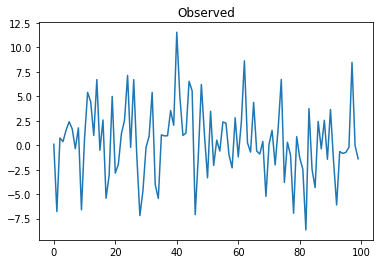

In [25]:
plt.plot(y)
plt.title('Observed')

In [26]:
def coordinate_descent(X: np.ndarray, y: np.ndarray, alpha: float, n_iter: int) -> np.ndarray:
    n_samples = X.shape[0]
    n_features = X.shape[1]
    w = np.zeros(n_features)
    for _ in range(n_iter):
        for j in range(n_features):
            w[j] = 0.0
            r_j = y - np.dot(X, w)
            s = np.dot(X[:, j], r_j) / n_samples
            w[j] = soft_threshold(np.dot(X[:, j], r_j) / n_samples, alpha)
    return w

In [27]:
%timeit coordinate_descent(X, y, alpha, n_iter)

4.75 s ± 888 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%cython -a
cimport numpy as np
import numpy as np

def soft_threshold(X, thresh):
    return np.where(np.abs(X) <= thresh, 0, X - thresh * np.sign(X))

def c_coordinate_descent(X, y, alpha, n_iter):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    w = np.zeros(n_features)
    for _ in range(n_iter):
        for j in range(n_features):
            w[j] = 0.0
            r_j = y - np.dot(X, w)
            w[j] = soft_threshold(np.dot(X[:, j], r_j) / n_samples, alpha)
    return w

In [29]:
%timeit c_coordinate_descent(X, y, alpha, n_iter)

3.7 s ± 405 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%cython -a
cimport numpy as np
import numpy as np

cimport cython

ctypedef fused numeric:
    np.int32_t
    np.int64_t    
    np.float32_t
    np.float64_t

cdef int sign(numeric X):
    return (X > 0) - (0 > X)

    
cdef double soft_threshold(numeric X, float thresh):
    cdef int is_positive = sign(X)    
    if is_positive * X <= thresh:
        return 0
    else:
        return X - is_positive * thresh


@cython.boundscheck(False)
@cython.wraparound(False)    
def c_coordinate_descent_typed(numeric [:,:] X, numeric [:] y, float alpha, Py_ssize_t n_iter):
    
    cdef Py_ssize_t j
    cdef Py_ssize_t n_samples = X.shape[0]
    cdef Py_ssize_t n_features = X.shape[1]
    cdef np.ndarray r_j
    cdef double s_j
    
    w_np = np.zeros(n_features, dtype=np.double)
    cdef double [:] w = w_np
    for _ in range(n_iter):
        for j in range(n_features):
            w[j] = 0.0
            r_j = y - np.dot(X, w_np)
            s_j = np.dot(X[:, j], r_j) / n_samples            
            w[j] = soft_threshold(<numeric>s_j, alpha)
    return w_np

In [31]:
%timeit c_coordinate_descent_typed(X, y, alpha, n_iter)

3.28 s ± 606 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
